<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC3</p>
<p style="margin: 0; text-align:right;">2018-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Alumno: <b>Fernando Antonio Barbeiro Campos</b> - <a>fbarbeiro@uoc.edu</a></p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 3: Redes neuronales recurrentes

En esta práctica trabajaremos con redes neuronales recurrentes en dos tipos de problemas:

<ol start="1">
  <li>En un problema de regresión con datos generados sintéticamente.</li>
  <li>En un problema de clasificación de textos.</li>
</ol>

**Importante: Cada uno de los ejercicios puede suponer varios minutos de ejecución, por lo que la entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File $\to$ Download as $\to$ HTML.**

## 0. Carga de librerías

El siguiente código carga los paquetes necesarios para los dos ejercicios de la práctica.

In [51]:
import tensorflow as tf
import random
from tensorflow import keras
import numpy as np
from stldecompose import decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from pandas import Series
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras import layers
from keras import Input
from keras.layers import GRU, Activation, Dropout, LSTM, Dense, Embedding
from keras.models import Model, Sequential
import os

## 1. Regresión con datos generados sintéticamente (5 puntos)

En este apartado trabajaremos con una serie temporal generada sintéticamente utilizando numpy. A continuación trataremos de eliminar tendencias y estacionalidades para preparar los datos y, finalmente, con los datos normalizados entrenaremos varios modelos que permitirán predecir los valores futuros de la serie.

### 1.1 Generación de datos

El siguiente código genera una serie temporal con cierta aleatoriedad, guarda la serie en la variable "serie" y la visualiza en una gráfica.

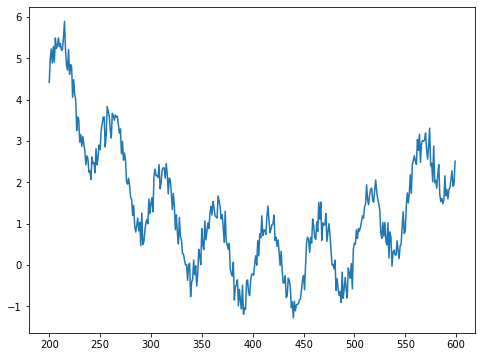

In [2]:
def f(x):
    return np.square(-x+425)/10000 + np.sin(x/8) + 0.25*np.random.randn()

idx = np.arange(200, 600)
serie = [f(x) for x in idx]

plt.rc("figure", figsize=(8,6))
plt.plot(idx, serie)
plt.show()

### 1.2 Eliminación de tendencia y estacionalidad

Para que la red neuronal pueda extraer patrones de la serie temporal es necesario transformar la serie para que los valores estén siempre en el mismo rango. Para ello, podemos extraer la tendencia y la estacionalidad de la serie y deshacer el cambio en el momento de obtener predicciones.


Calcular la periodicidad exacta a través de la fórmula de generación de datos. Comprovar que queda bien al aplicar el método. Poner como ejercicio provar diferentes valores de estacionalidad (múltiples i divisores y otros).

BONUS: Otras formas de eliminar tendencia y estacionalidad, pros y contras.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0,5 ptos):</strong> Calcular el periodo de la serie a partir de la fórmula que se ha utilizado para la generación de los datos.
</div>

In [3]:
peaks = 8
period = int(idx.size/peaks)
print("Periods: ", period)

Periods:  50


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0,5 ptos):</strong> Extraer la tendencia y la estacionalidad utilizando la función "decompose" del paquete "stldecompose" y dibujarla con el método "plot" de la misma librería.
</div>

In [4]:
def plot_decompose(ts, period=50):
    print('Valor periodo: ', period)
    stl = decompose(ts, period = period)
    stlplot = stl.plot()

Valor periodo:  50


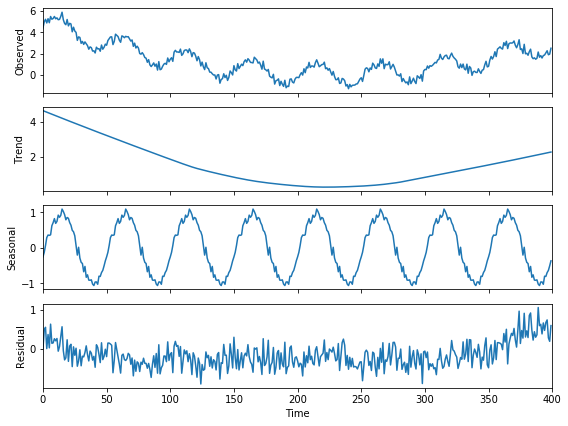

In [5]:
plot_decompose(serie, period)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0,5 ptos):</strong> Repetir la extracción de tendencia y estacionalidad utilizando diferentes valores para el periodo. Probar con valores múltiplos y divisores del periodo, así como con otros valores al azar.
</div>

Valor periodo:  100
Valor periodo:  150


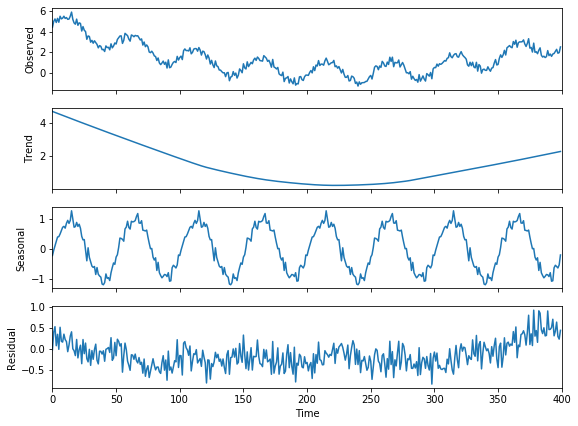

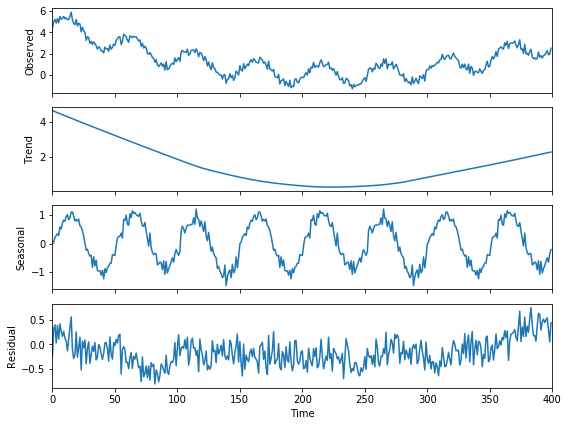

In [12]:
array =[100, 150]
for i in array:
    plot_decompose(serie, i)

Valor periodo:  25
Valor periodo:  10


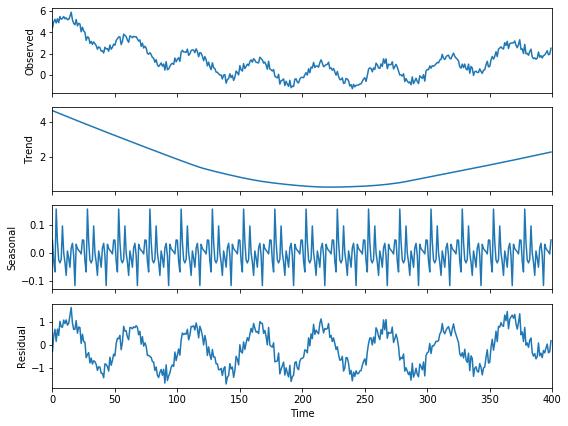

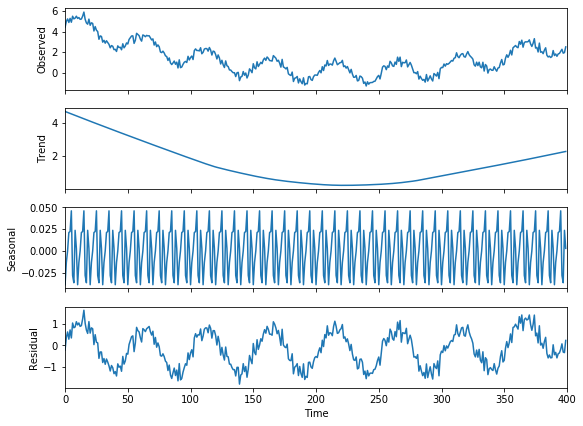

In [7]:
array =[25, 10]
for i in array:
    plot_decompose(serie, i)

Valor periodo:  85
Valor periodo:  27


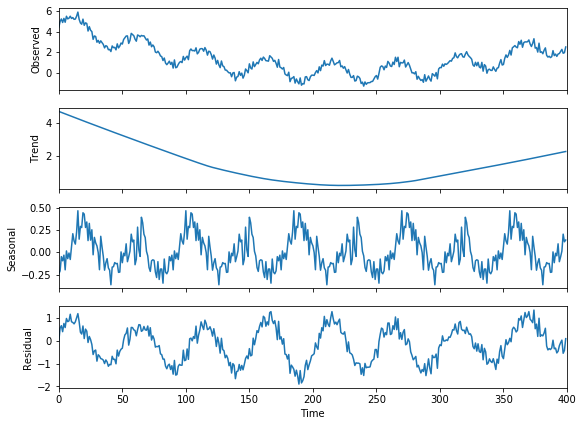

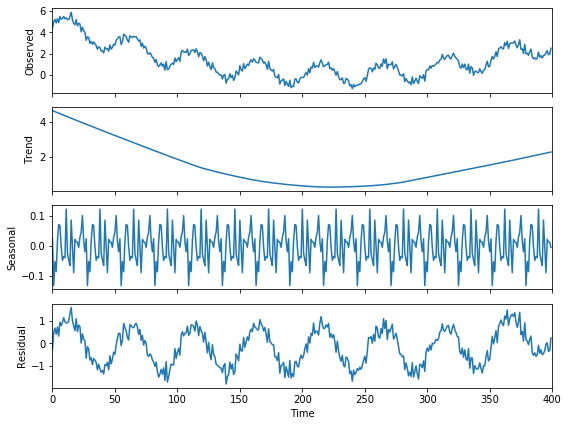

In [8]:
array = random.sample(range(25, 100), 2)
for i in array:
    plot_decompose(serie, i)

In [21]:
final_stl =  decompose(serie, period = period)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0,5 ptos):</strong> Analizar la importancia de calcular correctamente el periodo estacional de una serie temporal utilizando los resultados obtenidos anteriormente.
</div>

Según Chew [1] (adapatado para nuestros valores):

"*With STL, the thing that we're really controlling is the seasonality. What we're saying to the algorithm is that we believe that a period is `50`; therefore, please find a seasonality that fits. If we say to the algorithm that we believe that a period is `10`, the algorithm will try its best to find a seasonality and trend that fits that pattern*".

Dado el comentario arriba y también los cambios probando distintos valores, los valores multiplos como `100` y `150` (cuando no muy altos) aparentemente no presentaran impacto significativo en el grafico Seasonal. Mientras tanto, al disminuir los valores como el `period = 25` o `10` si que representa una afectación significativa. La importancia de tener un valor que refleje correctamente el periodo es literalmente identificar el patrón en la ventana temporal adecuada, evitando equivocos que pueden añadir algunos tipos de sesgo en nuestras predicciones de un modelo que vayamos a construir.

### 1.3 Predicción de la tendencia

La tendencia de una serie temporal cambia lentamente con el tiempo. Además, en el momento de realizar predicciones normalmente toma valores fuera del rango que aparece en los datos de entrenamiento. Esto fuerza al modelo a extrapolar, por lo que hay que utilizar modelos muy robustos para predecir la tendencia.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0,5 ptos):</strong> Entrenar un modelo polinomial con las variables $x$ y $x^2$ para predecir los valores de la tendencia en el conjunto de entrenamiento. Dibujar una gráfica con la tendencia original y su predicción.
</div>

In [163]:
from sklearn.preprocessing import PolynomialFeatures
import operator

polynomial_features = PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(idx.reshape(-1,1))
model_poly = LinearRegression()
model_poly.fit(x_poly, serie)
y_poly_pred = model_poly.predict(x_poly)

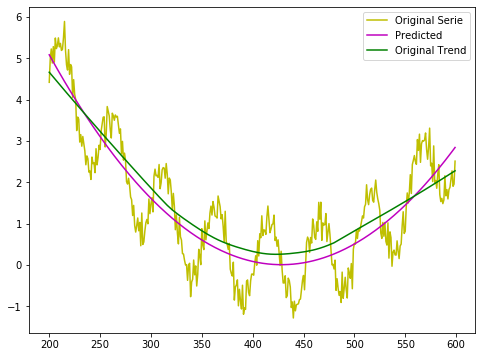

In [151]:
plt.plot(idx, serie, color='y', label="Original Serie")
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(idx, y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(idx, y_poly_pred, color='m', label="Predicted")
plt.plot(idx, final_stl.trend, color='g', label="Original Trend")
plt.legend()

plt.show()

### 1.4 Predicción de la parte estacionaria

Al descomponer la serie temporal obtenemos la estacionalidad como una nueva serie temporal que se repite cada cierto tiempo, por lo que es muy adecuada para predecirla utilizando una red neuronal recurrente. Dado que las redes neuronales repiten varias veces la misma operación sobre un conjunto de datos, es importante normalizar los valores para evitar problemas de explosión o desaparición del gradiente.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0,5 ptos):</strong> Normalizar los valores de la serie estacionaria a valores entre 0 y 1.
</div>

In [56]:
seasonal_not_norml = Series(final_stl.seasonal)
print("Cinco primeros valores:\n", seasonal_not_norml.head())

values = seasonal_not_norml.values
values = values.reshape((len(values), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)

print('\nValor Min: %f, Valor Max: %f\n' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print the first 5 rows
seasonal_norm = scaler.transform(values)
print("Mismos cinco valores después de normalizar: ")
for i in range(5):
    print(normalized[i])

print("\nComprovando que se trata de los valores originales, hay que coincidir con 1a lista (reverting): ")
inversed = scaler.inverse_transform(seasonal_norm)
for i in range(5):
    print(inversed[i])

Cinco primeros valores:
 0   -0.253525
1   -0.125575
2    0.066173
3    0.292259
4    0.363284
dtype: float64

Valor Min: -1.061341, Valor Max: 1.095712

Mismos cinco valores después de normalizar: 
[0.37449953]
[0.43381684]
[0.52271012]
[0.62752262]
[0.66044964]

Comprovando que se trata de los valores originales, hay que coincidir con 1a lista (reverting): 
[-0.25352547]
[-0.12557491]
[0.06617259]
[0.29225868]
[0.363284]


El siguiente código genera el dataset de entrenamiento de la red recurrente. Utilizando lookback = 30 cada ejemplo del dataset contiene los 30 últimos valores de la serie y su etiqueta corresponde al siguiente valor.

In [57]:
lookback = 30

features_set = [] 
labels = []  
for i in range(lookback, seasonal_norm.shape[0]):  
    features_set.append(seasonal_norm[i-lookback:i, 0])
    labels.append(seasonal_norm[i, 0])

features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0,5 ptos):</strong> Definir y entrenar una red neuronal recurrente con celdas GRU cuya salida esté formada por una capa completamente conectada de una única neurona con función de activación lineal.
</div>

In [152]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

def gru_model():
    model = Sequential()
    model.add(GRU(period, input_shape = (30,1), return_sequences=True))
    
    model.add(Dropout(0.1))
    model.add(GRU(1, return_sequences = False))
    model.add(Activation('linear'))
    
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model
    
model_gru = gru_model()
model_gru.fit(features_set, labels, batch_size = 10, epochs = 30, verbose = 1)

Epoch 1/30
370/370 [==============================] - 4s 12ms/step - loss: 0.0694
Epoch 2/30
370/370 [==============================] - 1s 3ms/step - loss: 0.0327
Epoch 3/30
370/370 [==============================] - 1s 3ms/step - loss: 0.0212
Epoch 4/30
370/370 [==============================] - 1s 3ms/step - loss: 0.0116
Epoch 5/30
370/370 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 6/30
370/370 [==============================] - 1s 3ms/step - loss: 0.0030
Epoch 7/30
370/370 [==============================] - 1s 3ms/step - loss: 0.0029
Epoch 8/30
370/370 [==============================] - 1s 3ms/step - loss: 0.0028
Epoch 9/30
370/370 [==============================] - 1s 3ms/step - loss: 0.0027
Epoch 10/30
370/370 [==============================] - 1s 3ms/step - loss: 0.0026
Epoch 11/30
370/370 [==============================] - 1s 3ms/step - loss: 0.0026
Epoch 12/30
370/370 [==============================] - 1s 3ms/step - loss: 0.0026
Epoch 13/30
370/370 [===

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0,5 ptos):</strong> Utilizar el modelo entrenado anteriormente para predecir los valores del conjunto de entrenamiento de la serie estacionaria. Dibujar una gráfica con la tendencia original y su predicción.
</div>

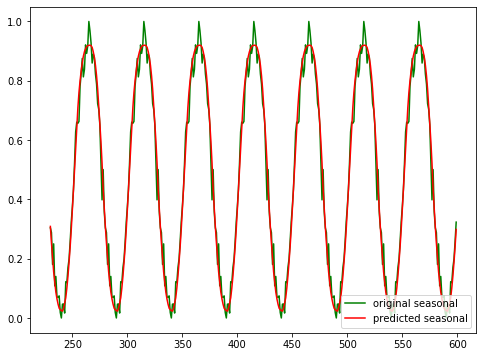

In [161]:
pred_gru = model_gru.predict(features_set)

seas_interested_id = seasonal_norm
seas_interested_id = seas_interested_id[lookback:]

plt.rc("figure", figsize=(8,6))
plt.plot(idx[lookback:], seas_interested_id, color='g', label="original seasonal")
plt.plot(idx[lookback:], pred_gru, color='r', label="predicted seasonal")
plt.legend(loc="lower right")
plt.show()

### 1.5 Predicción completa de la serie

Para predecir nuevos valores de la serie original es necesario realizar predicciones con los dos modelos, deshacer la normalización de la red neuronal y sumar las dos predicciones.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0,5 ptos):</strong> Calcular la predicción agregada de la serie original y dibujar en una gráfica las predicciones junto a los valores de la serie original.
</div>

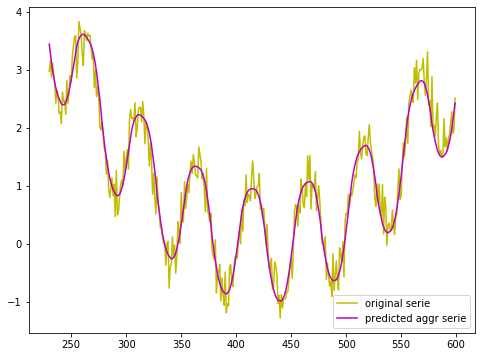

In [187]:
train_pred = np.add(scaler.inverse_transform(pred_gru).reshape(-1), y_poly_pred[lookback:])
plt.rc("figure", figsize=(8,6))
plt.plot(idx[lookback:], serie[lookback:], color='y', label="original serie")
plt.plot(idx[lookback:], train_pred, color='m', label="predicted aggr serie")
plt.legend(loc="lower right")
plt.show()

### 1.6 Predicción de valores futuros

A continuación generaremos nuevos valores de la serie sintética para comprobar el rendimiento de las predicciones.

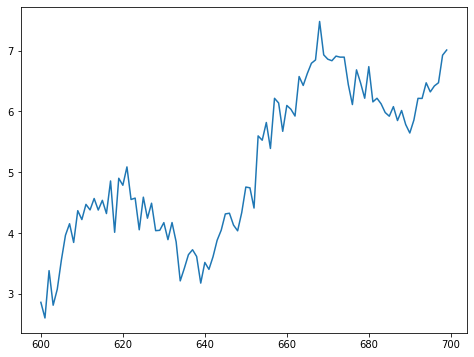

In [175]:
idx_new = np.arange(600, 700)
serie_new = [f(x) for x in idx_new]

plt.rc("figure", figsize=(8,6))
plt.plot(idx_new, serie_new)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0,5 ptos):</strong> Utilizar el modelo polinomial entrenado anteriormente para calcular la predicción de la tendencia en los nuevos valores de la serie.
</div>

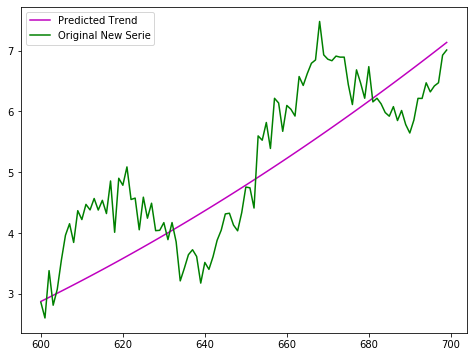

In [191]:
new_x_poly = polynomial_features.fit_transform(idx_new.reshape(-1,1))
pred_tendencia = model_poly.predict(new_x_poly)


sorted_zip = sorted(zip(idx_new, pred_tendencia), key=sort_axis)
new_x, pred_tendencia = zip(*sorted_zip)
plt.plot(idx_new, pred_tendencia, color='m', label="Predicted Trend")
plt.plot(idx_new, serie_new, color='g', label="Original New Serie")

plt.legend()


El siguiente código predice valores de la serie estacionaria uno a uno y utiliza los valores predichos como entrada para predecir los siguientes valores de la serie.

In [184]:
pre_data = seasonal_norm[-lookback:]
reg_orig = np.array(pre_data)

test_preds = []
for i in idx_new:
    reg_lstm = np.reshape(reg_orig, (1, reg_orig.shape[0], 1))
    test_pred = model.predict(reg_lstm)
    test_preds.append(test_pred)
    reg_orig = np.roll(reg_orig, -1)
    reg_orig[-1] = test_pred

test_preds = np.array(test_preds).reshape(-1, 1)

Finalmente podemos agregar las predicciones de los dos modelos para los nuevos valores y mostrar toda la información en una única gráfica.

In [185]:
test_pred = np.add(scaler.inverse_transform(test_preds).reshape(-1), pred_tendencia)

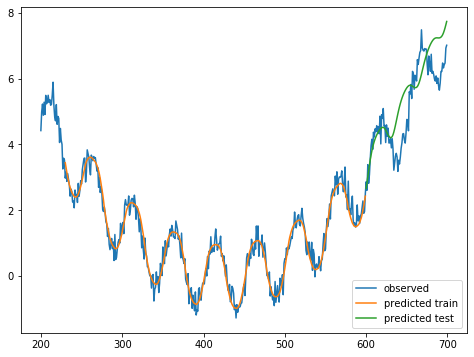

In [188]:
idx_global = np.arange(200, 700)
obs = np.hstack([serie, serie_new])

plt.rc("figure", figsize=(8,6))
plt.plot(idx_global, obs, label="observed")
plt.plot(idx[lookback:], train_pred, label="predicted train")
plt.plot(idx_new, test_pred, label="predicted test")
plt.legend(loc="lower right")
plt.show()

## 2. Clasificación de textos (5 puntos)

En este apartado trabajaremos con el conjunto de datos de noticias de Reuters clasificadas en 46 categorías diferentes. En lugar de clasificar la categoría para cada noticia, entrenaremos una red neuronal siamesa que prediga si dos noticias pertenecen a la misma categoría o no.

### 2.1 Carga y preprocesado de los datos

El siguiente código carga los datos de las noticias directamente del repositorio de Keras.

In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

print("Cargando datos...")
num_words = 10000
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = keras.datasets.reuters.load_data(num_words=num_words)
print("Finalizado")

np.load = np_load_old

Cargando datos...
Finalizado


Cada noticia tiene una longitud diferente pero, para facilitar el entrenamiento de la red neuronal recurrente, igualaremos la longitud de todas las secuencias utilizando un carácter especial de "padding".

In [3]:
longitud = 300
x_train = keras.preprocessing.sequence.pad_sequences(x_train_orig, maxlen=longitud)
x_test = keras.preprocessing.sequence.pad_sequences(x_test_orig, maxlen=longitud)

y_train = y_train_orig
y_test = y_test_orig

In [4]:
print(x_train.shape, "\t", x_test.shape)
print(y_train.shape, "\t", y_test.shape)

(8982, 300) 	 (2246, 300)
(8982,) 	 (2246,)


### 2.2 Preparación de los conjuntos de entrenamiento y test

Para entrenar un modelo que prediga si dos noticias pertenecen o no a la misma categoría debemos crear conjuntos de datos aparejados. El siguiente código genera los conjuntos de entrenamiento y test, cada uno con 20.000 parejas escogidas al azar. Es importante que las parejas para cada conjunto se generen de forma que las dos noticias que forman una pareja pertenezcan al mismo conjunto originalmente (entrenamiento o test), de forma que en el conjunto de parejas de test no aparezca en ningún caso una noticia que también estuviera en el conjunto de entrenamiento.

In [17]:
n_examples = 20000

train_pairs = np.random.choice(range(x_train.shape[0]), (n_examples, 2))
test_pairs = np.random.choice(range(x_test.shape[0]), (n_examples, 2))

In [18]:
x_train_left = x_train[train_pairs][:,0]
x_train_right = x_train[train_pairs][:,1]

y_train_pairs = y_train[train_pairs]
train_labels = (y_train_pairs[:,0] == y_train_pairs[:,1]).astype(np.int)

In [19]:
x_test_left = x_test[test_pairs][:,0]
x_test_right = x_test[test_pairs][:,1]

y_test_pairs = y_test[test_pairs]
test_labels = (y_test_pairs[:,0] == y_test_pairs[:,1]).astype(np.int)

In [20]:
print(x_train_left.shape, "\t", x_train_right.shape, "\t", y_train_pairs.shape, "\t", train_labels.shape)
print(x_test_left.shape, "\t", x_test_right.shape, "\t", y_test_pairs.shape, "\t", test_labels.shape)

(20000, 300) 	 (20000, 300) 	 (20000, 2) 	 (20000,)
(20000, 300) 	 (20000, 300) 	 (20000, 2) 	 (20000,)


### 2.3 Definición y entrenamiento de la red neuronal

A continuación utilizaremos una red recurrente siamesa para resolver el problema de clasificación que hemos preparado. Una red recurrente siamesa es una red neuronal que tiene una parte recurrente que se aplica a dos entradas diferentes para obtener una "codificación" (los mismos pesos se utilizan con las dos entradas por lo que no importa si, en una pareja, una noticia va en primera o en segunda posición). Entonces, la red siamesa contiene otra parte no recurrente que combina la codificación de las dos entradas para predecir una clasificacion.

El siguiente diagrama muestra la red neuronal recurrente que utilizaremos:
<img src="siamese_network.png" alt="Diagrama de la red neuronal siamesa" style="height: 500px;"/>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (2 ptos):</strong> Definir y entrenar la red neuronal recurrente que se muestra en el diagrama.
</div>

In [21]:
x_train_left.max()
x_train_left.shape[1:]

(300,)

In [23]:
layers.LSTM?

In [26]:
input1_tensor = Input(x_train_left.shape[1:])
input2_tensor = Input(x_train_right.shape[1:])

words_embedding_layer = Embedding(x_train_left.max() + 1, 100)
seq_embedding_layer = LSTM(1)

seq_embedding = lambda tensor: seq_embedding_layer(words_embedding_layer(tensor))

merge_layer = layers.multiply([seq_embedding(input1_tensor), seq_embedding(input2_tensor)])

dense1_layer = Dense(16, activation='sigmoid')(merge_layer)
ouput_layer = Dense(1, activation='sigmoid')(dense1_layer)

model_siam = Model([input1_tensor, input2_tensor], ouput_layer)

model_siam.compile(loss='binary_crossentropy', optimizer='adam')
model_siam.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 100)     1000000     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None

In [53]:
model_siam.fit([x_train_left, x_train_right], train_labels, batch_size=256, epochs=100, verbose=2) #          validation_data=([X1_val, X2_val], y_val), 

Epoch 1/100


KeyboardInterrupt: 

In [49]:
predict_siam_train = model_siam.predict([x_train_left, x_train_right])
predict_siam_test = model_siam.predict([x_test_left, x_test_right])

In [32]:
features_model = Model([input1_tensor, input2_tensor], merge_layer)
features_model.compile(loss='mse', optimizer='adam')

F_train = features_model.predict([x_train_left, x_train_right], batch_size=128)
F_val = features_model.predict([x_test_left, x_test_right], batch_size=128)

In [37]:
F_train[1111]

array([0.9996702], dtype=float32)

In [34]:
F_val

array([[-0.21334718],
       [ 0.06550739],
       [ 0.9983693 ],
       ...,
       [ 0.9966522 ],
       [ 0.9776853 ],
       [ 0.03432798]], dtype=float32)

In [ ]:
#https://www.kaggle.com/donniedarko/question-similarity-using-lstm-embedding

### 2.4 Análisis de los resultados

Dado que el problema de clasificación que hemos utilizado para entrenar la red neuronal tiene únicamente dos clases (0 y 1) una métrica muy útil para validar el rendimiento del modelo es el AUC ROC.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1,5 ptos):</strong> Utilizar el modelo para predecir la clasificación de las parejas tanto del conjunto de entrenamiento como del conjunto de test. A continuación, mostrar en una gráfica las curvas ROC para el conjunto de entrenamiento y para el de test y calcular el AUC ROC en cada caso.
</div>

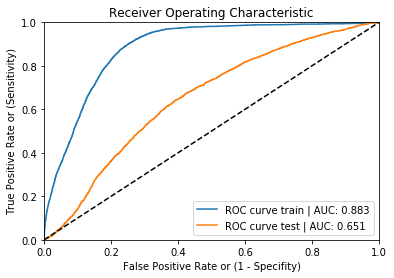

In [52]:

fpr_t, tpr_t, thresholds_t = roc_curve(train_labels, F_train)
fpr_t, tpr_t, thresholds_t = roc_curve(train_labels, predict_siam_train)
auc_t = roc_auc_score(train_labels, predict_siam_train)

fpr, tpr, thresholds = roc_curve(test_labels, F_val)
fpr, tpr, thresholds = roc_curve(test_labels, predict_siam_test)
auc = roc_auc_score(test_labels, predict_siam_test)


plt.plot(fpr_t, tpr_t, label='ROC curve train | AUC: %.3f' % auc_t)
plt.plot(fpr, tpr, label='ROC curve test | AUC: %.3f' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1,5 ptos):</strong> Comentar la relación entre el crecimiento de "True Positive Rate" y el crecimiento de "False Positive Rate".
</div>

# Referencias

**Chew, C. (2018)**. *Go Machine Learning Projects*. Published by Packt Publishing.